# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import *


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM') #all feature dataset
escapeHemo = pd.read_csv("Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM') #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM') #labels for prediction classes 

#Load validation
aricCohortHemo = pd.read_csv("Data Validation/ARIC/Preprocessed Data/Clustered_HemoDF_ARIC_Cohort.csv", sep=",", index_col='ID')
aricCohortAllData = pd.read_csv("Data Validation/ARIC/Preprocessed Data/Clustered_AllData_ARIC_Cohort.csv", sep=",", index_col='ID')
cohortLabels = pd.read_csv("Data Validation/ARIC/Original DataFrames/LabelsAricCohort.csv", sep=",", index_col='ID')

guideHemo = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/Clustered_HemoDF_GUIDE-IT.csv", sep=",", index_col='ID')
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/Clustered_AllData_GUIDE-IT.csv", sep=",", index_col='ID')
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID')


# Cluster Labels

In [3]:
#HELPER METHODS

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Score Label Preprocessing/Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return X

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

#         print("Cluster ", num)
#         print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

def runClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    y_model = clusterModel.fit_predict(data)

    #Save cluster model
    pickle.dump(clusterModel, open('Score Label Preprocessing/ClusterModels/' + modelName + '.sav', 'wb'))
    
    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    #Get real data with clusters
    hemoDF = copy.deepcopy(origData)
    hemoDF['cluster'] = y_model

    #add class labels
    hemoDF['Death'] = labels['Death']
    hemoDF['Rehosp'] = labels['Rehosp']
    hemoDF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(hemoDF, 5)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return hemoDF, descSummary

def runValidationClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    y_model = clusterModel.fit_predict(data) #TODO MIGHT NEED TO CHANGE THIS ONE
#     y_model = clusterModel.predict(data) #TODO MIGHT NEED TO CHANGE THIS ONE

    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    #Get real data with clusters
    hemoDF = copy.deepcopy(origData)
    hemoDF['cluster'] = y_model

    #add class labels
    try:
        hemoDF['Death'] = labels['Death']
    except:
        print("No Death Labels")
    try:
        hemoDF['Rehosp'] = labels['Rehosp']
    except:
        print("No Rehosp Labels")
    try:
        hemoDF['Readmission'] = labels['Readmission']
    except:
        print("No Readmission Labels")

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(hemoDF, 5)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return hemoDF, descSummary

def assignScoresFromClusters(descSummary):
    clsScDF = pd.DataFrame()
    clsScDF.index.name = 'Cluster'

    scores = [1,2,3,4,5]
    dthMn = descSummary.loc['mean']['Death'].to_numpy()
    rehospMn = descSummary.loc['mean']['Rehosp'].to_numpy()
    readmMn = descSummary.loc['mean']['Readmission'].to_numpy()
    
    dthScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(dthMn):
        dthScores[v] = scores[cnt]
        cnt += 1

    rehospScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(rehospMn):
        rehospScores[v] = scores[cnt]
        cnt += 1

    readmScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(readmMn):
        readmScores[v] = scores[cnt]
        cnt += 1

    clsScDF['DeathMean'] = dthMn
    clsScDF['DeathScores'] = dthScores
    clsScDF['RehospMean'] = rehospMn
    clsScDF['RehospScores'] = rehospScores
    clsScDF['ReadmMean'] = readmMn
    clsScDF['ReadmScores'] = readmScores

    aveScores = []
    for i in clsScDF.index:
        c = clsScDF.loc[i]
        a = c['DeathScores'] + c['RehospScores'] + c['ReadmScores']
        aveScores.append(a/3)

    clsScDF['AveScores'] = aveScores
    return clsScDF
    

def saveClusteredData(hemoDF, scoreAsmts, saveName):
    
    clusNums = hemoDF['cluster']

    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['FinalScores']))
    hemoDF['Score'] = labels

    #Death Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['DeathScores']))
    hemoDF['ScoreDeath'] = labels

    #Rehosp Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['RehospScores']))

    hemoDF['ScoreRehosp'] = labels

    #Readm Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['ReadmScores']))
    hemoDF['ScoreReadmission'] = labels

    hemoDF = hemoDF.drop(columns=["cluster"])
    hemoDF = hemoDF.drop(columns=["Death"])
    hemoDF = hemoDF.drop(columns=["Rehosp"])
    hemoDF = hemoDF.drop(columns=["Readmission"])

    hemoDF.to_csv(saveName)
    
    return hemoDF

# Cluster ESCAPE Hemo

In [4]:
# first - try other clustering methods

#try clustering to find similar groups using PCA
hemo = copy.deepcopy(escapeHemo)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
data=hemo
# scaler = MinMaxScaler()#scale data
# hemo.loc[:,:] = scaler.fit_transform(hemo)
# pca = PCA(n_components=2)
# data = pca.fit_transform(hemo)

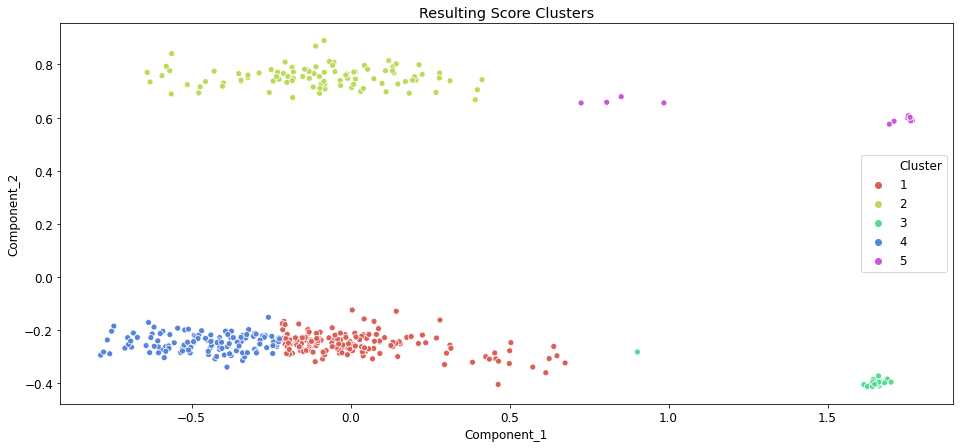

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,cluster,Death,Rehosp,Readmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,1,1,0
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,1,1,0
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,0,0,1,0
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,0,0,1,0
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,2,0,0,0
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,3,1,1,0
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,3,1,1,0


In [5]:
#TODO HERE- Choose clustering method
# ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')
# ac = KMeans(n_clusters=5)
ac = SpectralClustering(n_clusters=5, assign_labels='discretize')


hemoDF, descSummary = runClustering(clusterModel=ac, data=data, origData=escapeHemo, labels=escapeLabels, 
                                    modelName='AC_Hemo', columns=['MPAP', 'BPDIAS'], pca=False)
hemoDF

In [6]:
scoreAsmts = assignScoresFromClusters(descSummary)
scoreAsmts

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.302469,2,0.586420,5,0.166667,3,3.333333
1,0.257732,1,0.546392,3,0.144330,1,1.666667
2,0.384615,4,0.423077,1,0.230769,5,3.333333
3,0.325000,3,0.566667,4,0.175000,4,3.666667
4,0.384615,5,0.538462,2,0.153846,2,3.000000


In [7]:
#TODO - MUST ALWAYS ADD ASMTS HERE
#Note - higher average scores means worse outcomes
finalScores = [3, 1, 4, 5, 2]
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.302469,2,0.586420,5,0.166667,3,3.333333,3
1,0.257732,1,0.546392,3,0.144330,1,1.666667,1
2,0.384615,4,0.423077,1,0.230769,5,3.333333,4
3,0.325000,3,0.566667,4,0.175000,4,3.666667,5
4,0.384615,5,0.538462,2,0.153846,2,3.000000,2


In [8]:
hemoDF = saveClusteredData(hemoDF, scoreAsmts,"Data/Preprocessed Data/ESCAPE_AC_Hemo.csv")
hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,1,3,1
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,1,3,1
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,3,2,5,3
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,3,2,5,3
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,3,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,4,4,1,5
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,5,3,4,4
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,5,3,4,4


# Cluster ARIC Cohort Hemo

In [9]:
#Fix labels that only have death
cohortLabels['Rehosp']=0
cohortLabels['Readmission']=0
cohortLabels

,Death,Rehosp,Readmission
ID,,,
S105655,0,0,0
S105737,0,0,0
S106083,0,0,0
S106142,0,0,0
S106248,1,0,0
...,...,...,...
S214719,0,0,0
S214738,0,0,0
S214744,0,0,0


In [10]:
hemo = copy.deepcopy(aricCohortHemo)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
data=hemo

# scaler = MinMaxScaler()#scale data
# hemo.loc[:,:] = scaler.fit_transform(hemo)
# pca = PCA(n_components=2)
# data = pca.fit_transform(hemo)

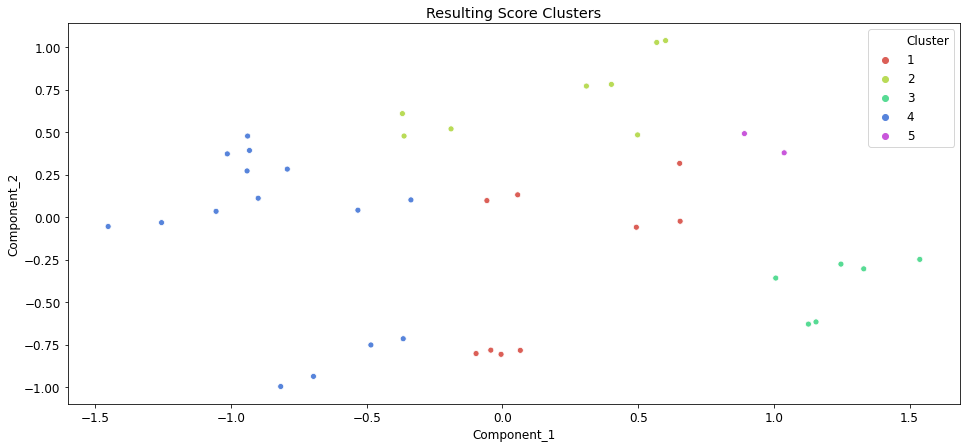

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,0.794118,0,2.347826,39.0,2.160000,3,0,0,0,0
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,0.735294,0,2.173913,33.0,2.000000,3,0,0,0,0
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,1.210526,0,5.750000,51.0,8.625000,5,3,0,0,0
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,1.456140,0,6.916667,63.0,10.375000,5,3,0,0,0
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.466667,0,1.680000,46.0,2.800000,5,3,1,0,0
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.288889,0,1.040000,29.0,1.733333,5,3,1,0,0
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,0.520408,0,25.500000,90.0,-25.500000,4,1,0,0,0
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,0.551020,0,27.000000,92.0,-27.000000,4,1,0,0,0
S116317,74,1,2,45.0,NaN,NaN,0,0,15.0,NaN,...,0.604167,0,3.866667,37.0,NaN,4,1,1,0,0


In [11]:
#TODO - update model here
model = pickle.load(open('Score Label Preprocessing/ClusterModels/AC_Hemo.sav', 'rb'))
hemoDF, descSummary = runValidationClustering(clusterModel=model, data=data, origData=aricCohortHemo, labels=cohortLabels, 
                                    modelName= "ARIC_Cohort_Cluster",columns=['MPAP', 'BPDIAS'], pca=False)
hemoDF

In [12]:
scoreAsmts = assignScoresFromClusters(descSummary)
scoreAsmts

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.000,1,0.0,1,0.0,1,1.000000
1,0.125,4,0.0,2,0.0,2,2.666667
2,0.000,2,0.0,3,0.0,3,2.666667
3,0.600,5,0.0,4,0.0,4,4.333333
4,0.000,3,0.0,5,0.0,5,4.333333


In [13]:
#TODO - MUST ALWAYS ADD ASMTS HERE
#Note - higher average scores means worse outcomes
finalScores = [1,4,2,5,3]
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.000,1,0.0,1,0.0,1,1.000000,1
1,0.125,4,0.0,2,0.0,2,2.666667,4
2,0.000,2,0.0,3,0.0,3,2.666667,2
3,0.600,5,0.0,4,0.0,4,4.333333,5
4,0.000,3,0.0,5,0.0,5,4.333333,3


In [14]:
hemoDF = saveClusteredData(hemoDF, scoreAsmts,"Data Validation/ARIC/Preprocessed Data/ARIC_Cohort_AC_Hemo.csv")
hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath,Score,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,1.086957,0.794118,0,2.347826,39.0,2.160000,1,1,1,1
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,1.086957,0.735294,0,2.173913,33.0,2.000000,1,1,1,1
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.666667,1.210526,0,5.750000,51.0,8.625000,5,5,4,4
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.666667,1.456140,0,6.916667,63.0,10.375000,5,5,4,4
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.600000,0.466667,0,1.680000,46.0,2.800000,5,5,4,4
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.600000,0.288889,0,1.040000,29.0,1.733333,5,5,4,4
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,-1.000000,0.520408,0,25.500000,90.0,-25.500000,4,4,2,2
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,-1.000000,0.551020,0,27.000000,92.0,-27.000000,4,4,2,2
S116317,74,1,2,45.0,NaN,NaN,0,0,15.0,NaN,...,NaN,0.604167,0,3.866667,37.0,NaN,4,4,2,2


# Cluster GUIDE-IT Hemo

In [10]:
hemo = copy.deepcopy(guideHemo)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)
data=hemo

# scaler = MinMaxScaler()#scale data
# hemo.loc[:,:] = scaler.fit_transform(hemo)
# pca = PCA(n_components=2)
# data = pca.fit_transform(hemo)

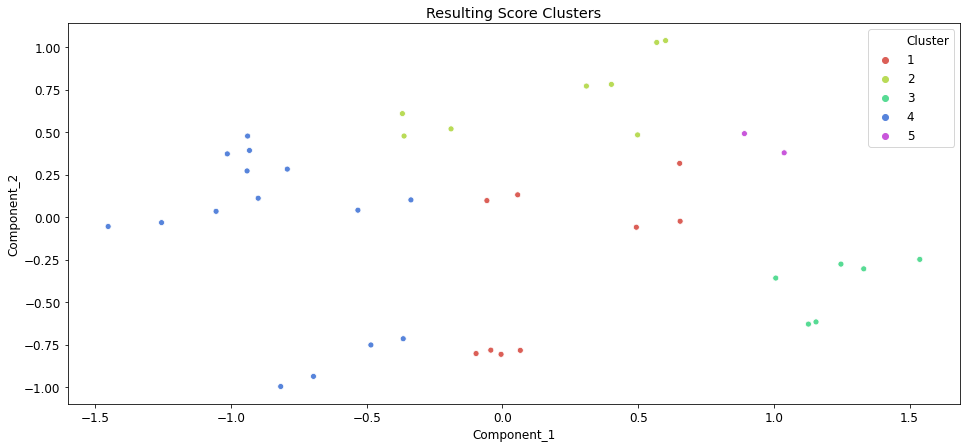

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,0.794118,0,2.347826,39.0,2.160000,3,0,0,0,0
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,0.735294,0,2.173913,33.0,2.000000,3,0,0,0,0
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,1.210526,0,5.750000,51.0,8.625000,5,3,0,0,0
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,1.456140,0,6.916667,63.0,10.375000,5,3,0,0,0
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.466667,0,1.680000,46.0,2.800000,5,3,1,0,0
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.288889,0,1.040000,29.0,1.733333,5,3,1,0,0
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,0.520408,0,25.500000,90.0,-25.500000,4,1,0,0,0
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,0.551020,0,27.000000,92.0,-27.000000,4,1,0,0,0
S116317,74,1,2,45.0,NaN,NaN,0,0,15.0,NaN,...,0.604167,0,3.866667,37.0,NaN,4,1,1,0,0


In [11]:
#TODO - update model here
model = pickle.load(open('Score Label Preprocessing/ClusterModels/AC_Hemo.sav', 'rb'))
hemoDF, descSummary = runValidationClustering(clusterModel=model, data=data, origData=aricCohortHemo, labels=cohortLabels, 
                                    modelName= "GUIDE-IT_Cluster",columns=['MPAP', 'BPDIAS'], pca=False)
hemoDF

In [12]:
scoreAsmts = assignScoresFromClusters(descSummary)
scoreAsmts

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.000,1,0.0,1,0.0,1,1.000000
1,0.125,4,0.0,2,0.0,2,2.666667
2,0.000,2,0.0,3,0.0,3,2.666667
3,0.600,5,0.0,4,0.0,4,4.333333
4,0.000,3,0.0,5,0.0,5,4.333333


In [13]:
#TODO - MUST ALWAYS ADD ASMTS HERE
#Note - higher average scores means worse outcomes
finalScores = [1,4,2,5,3]
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.000,1,0.0,1,0.0,1,1.000000,1
1,0.125,4,0.0,2,0.0,2,2.666667,4
2,0.000,2,0.0,3,0.0,3,2.666667,2
3,0.600,5,0.0,4,0.0,4,4.333333,5
4,0.000,3,0.0,5,0.0,5,4.333333,3


In [14]:
hemoDF = saveClusteredData(hemoDF, scoreAsmts,"Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AC_Hemo.csv")
hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,ScoreDeath,Score,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,1.086957,0.794118,0,2.347826,39.0,2.160000,1,1,1,1
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,1.086957,0.735294,0,2.173913,33.0,2.000000,1,1,1,1
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.666667,1.210526,0,5.750000,51.0,8.625000,5,5,4,4
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.666667,1.456140,0,6.916667,63.0,10.375000,5,5,4,4
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.600000,0.466667,0,1.680000,46.0,2.800000,5,5,4,4
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.600000,0.288889,0,1.040000,29.0,1.733333,5,5,4,4
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,-1.000000,0.520408,0,25.500000,90.0,-25.500000,4,4,2,2
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,-1.000000,0.551020,0,27.000000,92.0,-27.000000,4,4,2,2
S116317,74,1,2,45.0,NaN,NaN,0,0,15.0,NaN,...,NaN,0.604167,0,3.866667,37.0,NaN,4,4,2,2
